In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [3]:
df = pd.read_excel("./HPCGResults.xlsx")
df = df[df["HPCG Set Runtime(s)"] != 1800] # Remove long test runs
df_nodes = df.groupby("Nodes")
df.head(10)

C:\Users\ewanh\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\ewanh\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


,Nodes,JobID,N dimensions,HPCG Set Runtime(s),Bmk Time(s),Job Runtime(s),Performance(GFLOPs),Energy(J),Bmk Power(W),Job Power(W),Bmk Energy Efficiency(GFLOPs/W),Job Energy Efficiency(GFLOPs/W),Memory Usage(GB),Available Memory(GB),% Memory Used
0,1,11356983,32,60,60.8847,85,53.5293,35010,575.021311,411.882353,0.093091,0.129963,3.00637,256,0.011744
1,1,11354453,64,60,70.6205,130,44.2674,48238,683.059452,371.061538,0.064808,0.119299,24.01520,256,0.093809
2,1,11341079,104,60,62.4353,244,43.0891,91298,1462.281754,374.172131,0.029467,0.115158,102.99200,256,0.402313
4,1,11354913,120,60,98.4696,370,41.9946,136438,1385.584993,368.751351,0.030308,0.113883,158.19700,256,0.617957
5,1,11357010,128,60,120.1870,448,41.7663,166085,1381.888224,370.725446,0.030224,0.112661,191.98300,256,0.749934
7,2,11356943,32,60,60.2280,89,103.3670,63501,1054.343495,713.494382,0.098039,0.144874,6.01273,512,0.011744
8,2,11356587,64,60,71.2881,132,87.8310,97077,1361.756029,735.431818,0.064498,0.119428,48.03040,512,0.093809
9,2,11355857,104,60,63.0210,252,85.4522,185072,2936.671903,734.412698,0.029098,0.116354,205.98500,512,0.402314
10,2,11354951,120,60,98.7617,370,83.8046,287881,2914.905272,778.056757,0.028750,0.107710,316.39400,512,0.617957
11,2,11354443,128,60,120.3500,447,83.4796,339301,2819.285418,759.062640,0.029610,0.109977,383.96700,512,0.749936


In [4]:
df.shape

(40, 15)

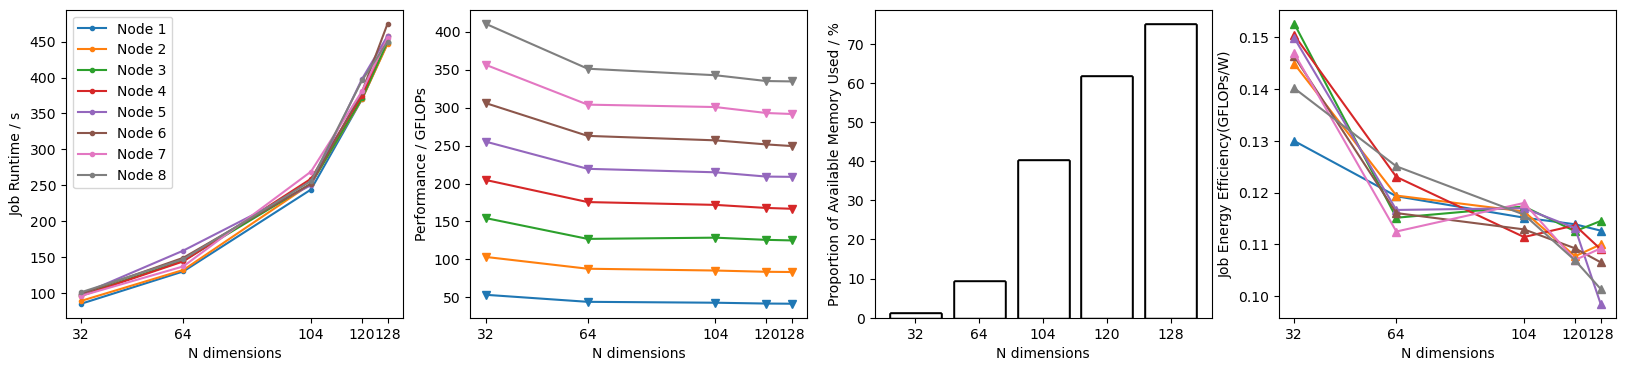

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
dims = [32, 64, 104, 120, 128]

# Runtime
for i in range(1, 9):
    df_curr_node = df_nodes.get_group(i)
    ax[0].plot(df_curr_node["N dimensions"], df_curr_node["Job Runtime(s)"], marker=".", label=f"Node {i}")
    ax[0].set_xticks(dims)
    ax[0].set_xlabel("N dimensions")
    ax[0].set_ylabel("Job Runtime / s")
    ax[0].legend()

# Performance
for i in range(1, 9):
    df_curr_node = df_nodes.get_group(i)
    ax[1].plot(df_curr_node["N dimensions"], df_curr_node["Performance(GFLOPs)"], marker="v", label=f"Node {i}")
    ax[1].set_xticks(dims)
    ax[1].set_xlabel("N dimensions")
    ax[1].set_ylabel("Performance / GFLOPs")

# Memory Usage
for i in range(1, 9):
    df_curr_node = df_nodes.get_group(i)
    ax[2].bar([str(dim) for dim in dims], 100 * df_curr_node["% Memory Used"], label=f"Node {i}", facecolor="white", edgecolor="black")
    ax[2].set_xlabel("N dimensions")
    ax[2].set_ylabel("Proportion of Available Memory Used / %")

# Efficiency
for i in range(1, 9):
    df_curr_node = df_nodes.get_group(i)
    ax[3].plot(df_curr_node["N dimensions"], df_curr_node["Job Energy Efficiency(GFLOPs/W)"], marker="^", label=f"Node {i}")
    ax[3].set_xticks(dims)
    ax[3].set_xlabel("N dimensions")
    ax[3].set_ylabel("Job Energy Efficiency(GFLOPs/W)")

fig.savefig("dimensions.png")

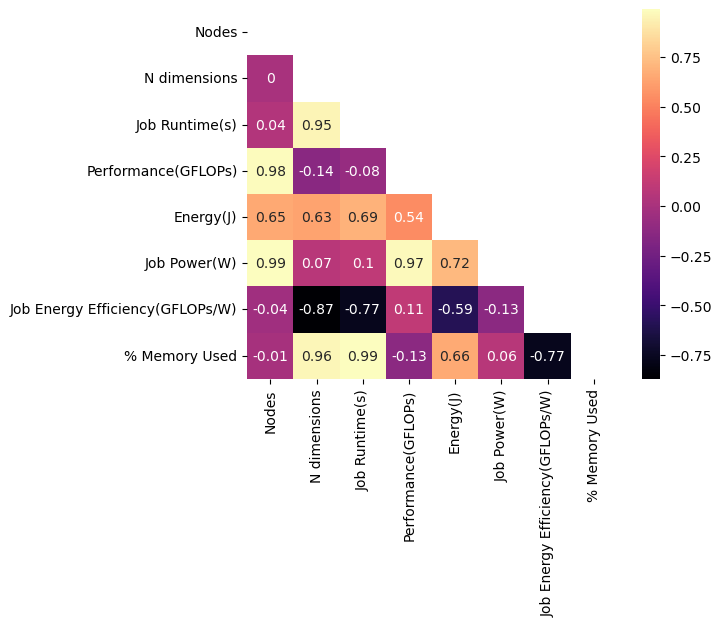

In [16]:
df_corr = df.copy().drop(columns=[
    "HPCG Set Runtime(s)",
    "JobID",
    "Bmk Time(s)",
    "Bmk Power(W)",
    "Bmk Energy Efficiency(GFLOPs/W)",
    "Memory Usage(GB)",
    "Available Memory(GB)"
])
N = len(df_corr.columns)
corr = df_corr.corr()
sns.heatmap(np.round(df_corr.corr(), 2), cmap="magma", annot=True, square=True, mask=np.triu(np.ones_like(df_corr.corr())))

plt.savefig("heatmap.png")

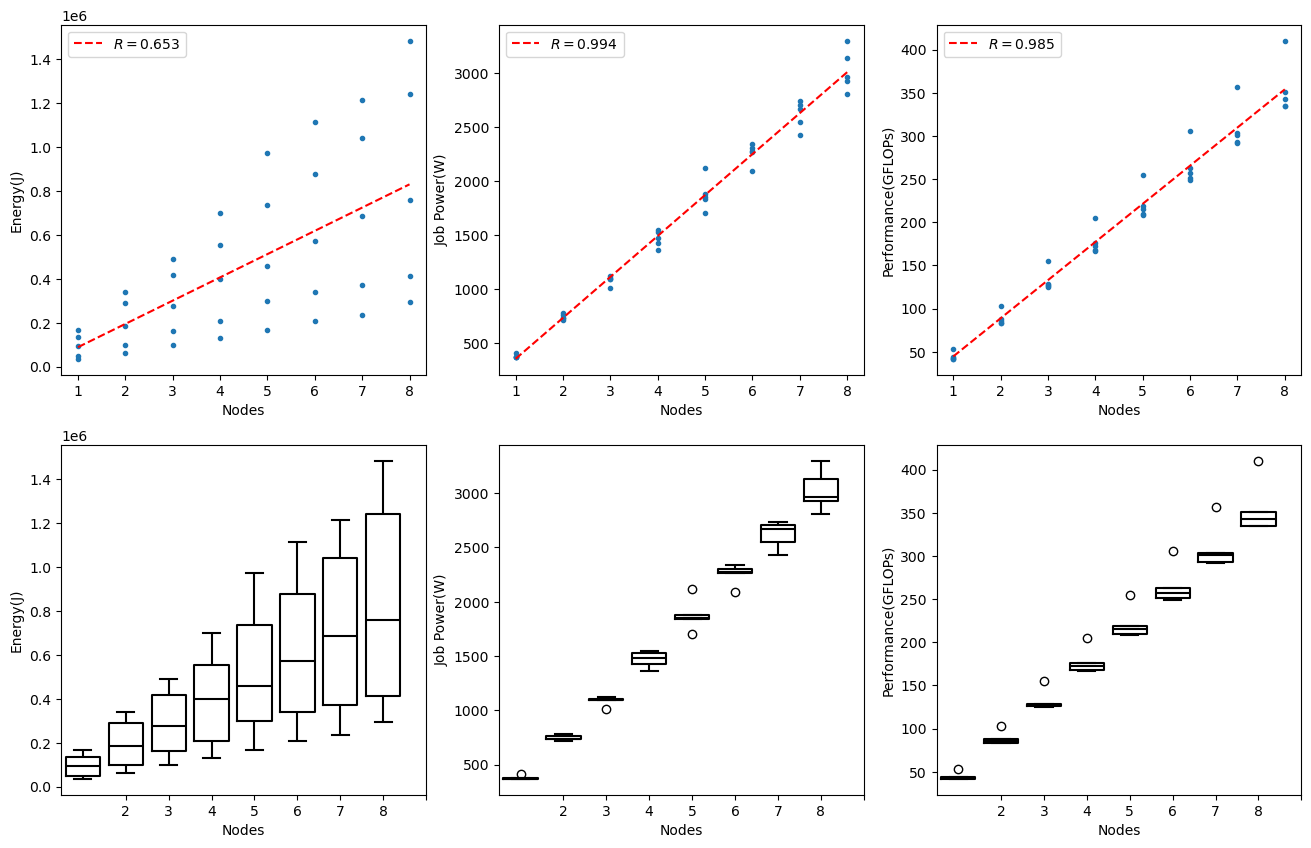

In [17]:
node_comps = ["Energy(J)", "Job Power(W)", "Performance(GFLOPs)"]
fig, ax = plt.subplots(ncols=len(node_comps), nrows=2, figsize=(16, 10))

for i, comp in enumerate(node_comps):
    result = linregress(df["Nodes"], df[comp])
    X = np.arange(1, df["Nodes"].max()+1)
    
    ax[0][i].scatter(df["Nodes"], df[comp], marker=".")
    ax[0][i].plot(X, result.slope*X + result.intercept, label=rf"$R={result.rvalue:.3f}$", linestyle="dashed", color="red")
    
    ax[0][i].set_xlabel("Nodes")
    ax[0][i].set_xticks(np.arange(1, df["Nodes"].max()+1))
    ax[0][i].set_ylabel(comp)
    ax[0][i].legend()

    b = sns.boxplot(x="Nodes", y=comp, data=df, ax=ax[1][i], fill=False, color="black")
    b.set_xticks(np.arange(1, df["Nodes"].max()+1))

fig.savefig("nodes.png")

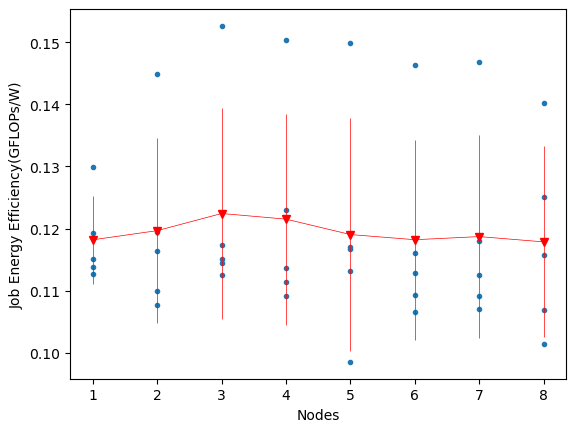

In [18]:
plt.scatter(df["Nodes"], df["Job Energy Efficiency(GFLOPs/W)"], marker=".")

nodes_n = np.arange(1, 9)
avgs = np.zeros(8)
errs = np.zeros(8)

for i in range(8):
    avgs[i] = df_nodes.get_group(i+1)["Job Energy Efficiency(GFLOPs/W)"].mean()
    errs[i] = df_nodes.get_group(i+1)["Job Energy Efficiency(GFLOPs/W)"].std()

plt.errorbar(nodes_n, avgs, yerr=errs, marker="v", color="red", linewidth=0.5)

plt.xlabel("Nodes")
plt.ylabel("Job Energy Efficiency(GFLOPs/W)")

plt.savefig("efficiency.png")